# Modulation of spatial attention in Vision Transformer (ViT)

Author: Hyunwoo Gu (22.07.13.)

---

References
+ Vision Transformer by Dosovitskiy *et al.* (2021) (https://arxiv.org/abs/2010.11929)
+ `jeonsworld`'s implementation of attention map (https://github.com/jeonsworld/ViT-pytorch/blob/main/visualize_attention_map.ipynb)
+ `EliSchwartz`'s imagenet sample images https://github.com/EliSchwartz/imagenet-sample-images

In [1]:
import os
import cv2
import numpy as np

import torch
from torchvision import transforms
from transformers import ViTFeatureExtractor, ViTForImageClassification
from PIL import Image

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['image.aspect'] = 'auto'

In [2]:
# load some imagenet images
img_dir   = 'images/'
img_files = os.listdir(img_dir)
img_files = sorted([f.lower() for f in img_files])

images = {}
for _, v_img in enumerate(img_files):
    name = v_img.split('_', 1)[-1].split('.jpeg')[0]
    image = Image.open(img_dir + v_img)
    images[name] = image

### 1. Attention maps

Self-attention matrix of layer $l$ is calculated as a softmax of dot product as follows:

$$
\mathbf{A}^l = \mathrm{softmax}\left( \frac{\left( \mathbf{H}^l \mathbf{W}^l_Q \right) \left( \mathbf{H}^l \mathbf{W}^l_K \right)^T}{\sqrt{d}} \right)
$$

where the computations for the class-token, biases, and residual connections are omitted for simplicity. Attention map is calculated by taking an arbitrary row $\mathbf{a}^l$ from $\mathbf{A}^l$, and cumulatively multiplying all the layers as follows:

$$
\mathrm{Attention Map} = \mathbf{a}^1 \odot \cdots \odot \mathbf{a}^{12}
$$

which is basically equivalent to [attention flow](https://arxiv.org/abs/2005.00928).

In [3]:
# load pretrained ViT
gridsize   = 14
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
model.eval()
print('model loaded')

model loaded


In [4]:
def compute_attention_map(attentions, grid_size=14):
    # Average the attention weights across all heads.
    att_mat = torch.stack(attentions).squeeze(1)
    att_mat = torch.mean(att_mat, dim=1)
    
    # To account for residual connections, we add an identity matrix to the attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat  = att_mat + residual_att
    aug_att_mat  = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

    # Attention from the output token to the input space.
    v = joint_attentions[-1]
    attn_map   = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    
    return attn_map

In [5]:
map_single = np.zeros([len(images),gridsize,gridsize]) * np.nan
idx_single = np.zeros([len(images)]) * np.nan
for i_i, (i_k, i_v) in enumerate(images.items()): 
    x      = preprocess(i_v)
    inputs = feature_extractor(images=x, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    logits, attentions = outputs['logits'], outputs['attentions']    
    
    # compute class predictions 
    probs = torch.nn.Softmax(dim=-1)(logits)
    idx_single[i_i] = torch.argmax(probs).item()
    
    # compute attention maps
    attn_map = compute_attention_map(attentions)
    map_single[i_i] = attn_map
    print(f'Ground-truth : {i_k} \nPrediction : {model.config.id2label[idx_single[i_i]]}\n')

Ground-truth : goldfish 
Prediction : goldfish, Carassius auratus

Ground-truth : jacamar 
Prediction : jacamar

Ground-truth : king_penguin 
Prediction : king penguin, Aptenodytes patagonica

Ground-truth : greater_swiss_mountain_dog 
Prediction : Greater Swiss Mountain dog

Ground-truth : llama 
Prediction : llama

Ground-truth : mink 
Prediction : mink

Ground-truth : chimpanzee 
Prediction : chimpanzee, chimp, Pan troglodytes

Ground-truth : squirrel_monkey 
Prediction : squirrel monkey, Saimiri sciureus

Ground-truth : bottlecap 
Prediction : bottlecap

Ground-truth : cornet 
Prediction : cornet, horn, trumpet, trump

Ground-truth : drum 
Prediction : drum, membranophone, tympan

Ground-truth : flagpole 
Prediction : flagpole, flagstaff

Ground-truth : mailbag 
Prediction : mailbag, postbag

Ground-truth : ski 
Prediction : ski

Ground-truth : stopwatch 
Prediction : stopwatch, stop watch

Ground-truth : traffic_light 
Prediction : traffic light, traffic signal, stoplight

Ground-

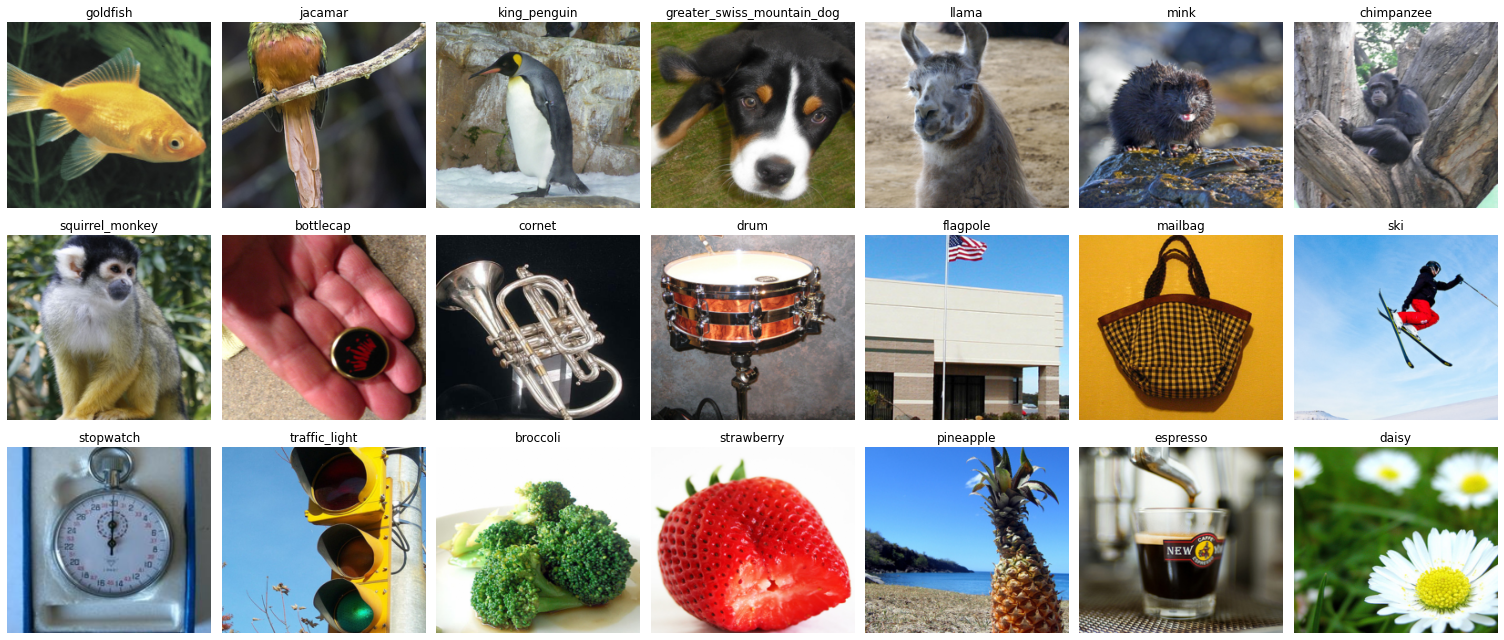

In [6]:
f,ax = plt.subplots(3,7, figsize=[21,9])

for i_fig in range(21):
    ii, jj = divmod(i_fig,7)
    x = preprocess(images[list(images.keys())[i_fig]])
    ax[ii,jj].imshow(x.detach().numpy().transpose((1,2,0)))
    ax[ii,jj].set_title(list(images.keys())[i_fig])
    ax[ii,jj].axis('off')
plt.tight_layout()
plt.show()

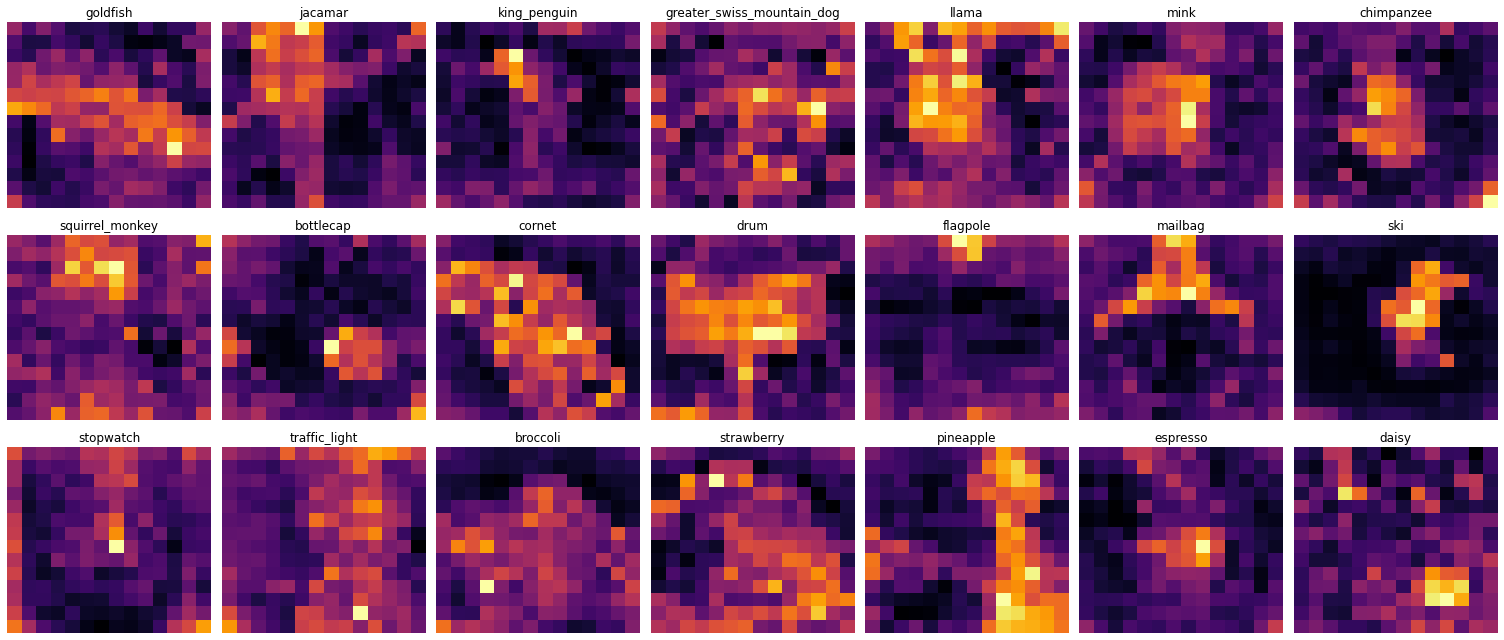

In [7]:
f,ax = plt.subplots(3,7, figsize=[21,9])

for i_fig in range(21):
    ii, jj = divmod(i_fig,7)
    ax[ii,jj].imshow(map_single[i_fig], cmap='inferno')
    ax[ii,jj].set_title(list(images.keys())[i_fig])
    ax[ii,jj].axis('off')
plt.tight_layout()
plt.show()

---
### 2. Contrast modulation

In [18]:
# select two images
img1, img2 = 9, 18
image_list = np.array(list(images.keys()))

print(f'Selected: Left image ({image_list[img1]}), Right image ({image_list[img2]})')

Selected: Left image (cornet), Right image (pineapple)


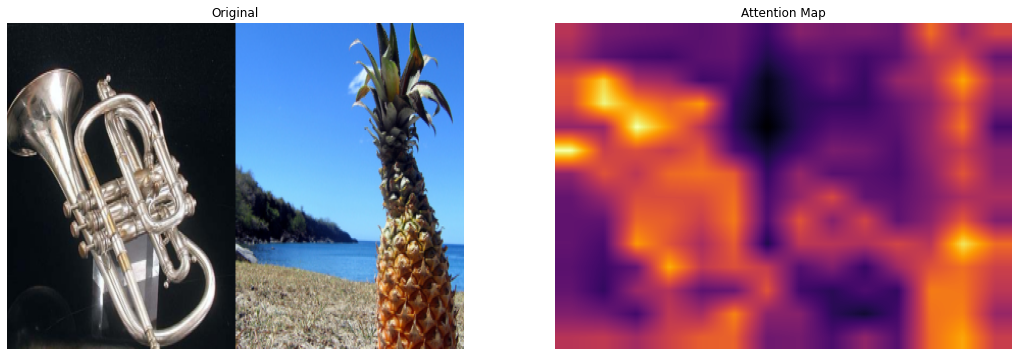

Predicted label: cornet, horn, trumpet, trump


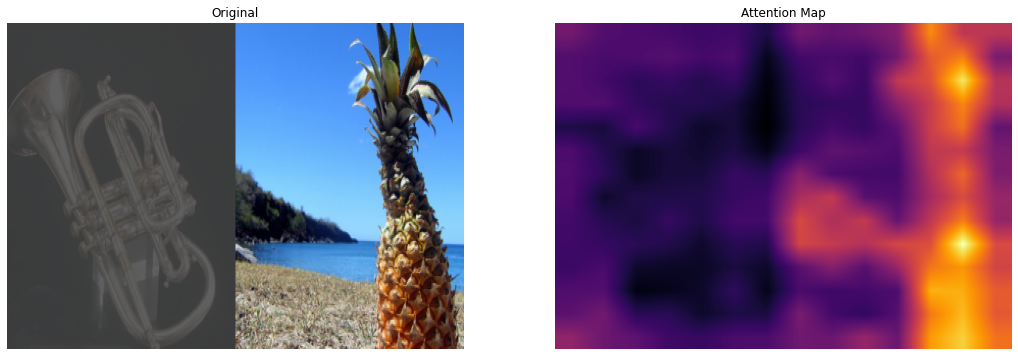

Predicted label: pineapple, ananas


In [22]:
image1  = preprocess(images[image_list[img1]])
image2  = preprocess(images[image_list[img2]])

# contrast modulation of the left image
for i, contrast in enumerate([1.0, 0.15]):
    image1_c = transforms.functional.adjust_contrast(image1, contrast_factor=contrast)    
    x        = torch.concat([image1_c,image2],axis=-1)
    inputs   = feature_extractor(images=x, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
    logits, attentions = outputs['logits'], outputs['attentions']    

    # 
    probs    = torch.nn.Softmax(dim=-1)(logits)
    idx      = torch.argmax(probs).item()
    attn_map = compute_attention_map(attentions)
    attn_map = cv2.resize(attn_map / attn_map.max(), x.shape[1:])[..., np.newaxis] # smoothing the map
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))
    ax1.set_title('Original')
    ax2.set_title('Attention Map')
    _ = ax1.imshow(x.detach().numpy().transpose((1,2,0))) # x.detach().numpy().transpose((1,2,0))
    _ = ax2.imshow(attn_map, cmap='inferno')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    
    print(f'Predicted label: {model.config.id2label[idx]}')

In [20]:
contrasts      = np.linspace(0,1,num=11)
maps_contrast  = np.zeros([len(contrasts),len(contrasts),14,14]) * np.nan
prob_contrast  = np.zeros([len(contrasts),len(contrasts),2]) * np.nan

print('Warning: this block can take some minutes!')
for ic_i, ic_v in enumerate(contrasts):
    for jc_i, jc_v in enumerate(contrasts):
        image1 = preprocess(images[image_list[img1]])
        image1 = transforms.functional.adjust_contrast(image1, contrast_factor=ic_v) # 0.75, 0.8, # 0.15, 0.2
        image2 = preprocess(images[image_list[img2]])
        image2 = transforms.functional.adjust_contrast(image2, contrast_factor=jc_v) # 0.75, 0.8, # 0.15, 0.2
        x      = torch.concat([image1,image2],axis=-1)
        inputs = feature_extractor(images=x, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs, output_attentions=True)
        logits, attentions = outputs['logits'], outputs['attentions']

        # 
        probs = torch.nn.Softmax(dim=-1)(logits)
        prob_contrast[ic_i,jc_i,0] = probs[0,int(idx_single[img1])].item()
        prob_contrast[ic_i,jc_i,1] = probs[0,int(idx_single[img2])].item()
        
        attn_map = compute_attention_map(attentions)
        maps_contrast[ic_i,jc_i] = attn_map
        
    print(f'Done:\t{np.round((ic_i+1)/11.*100)}%')
    
log_ratio = np.log(prob_contrast[:,:,0]/prob_contrast[:,:,1])

Done:	9.0%
Done:	18.0%
Done:	27.0%
Done:	36.0%
Done:	45.0%
Done:	55.0%
Done:	64.0%
Done:	73.0%
Done:	82.0%
Done:	91.0%
Done:	100.0%


#### 2.1. Contrast modulation plot

`viridis` colormap denotes the network classification preference for the left part, whereas `inferno` colormap for the right part.

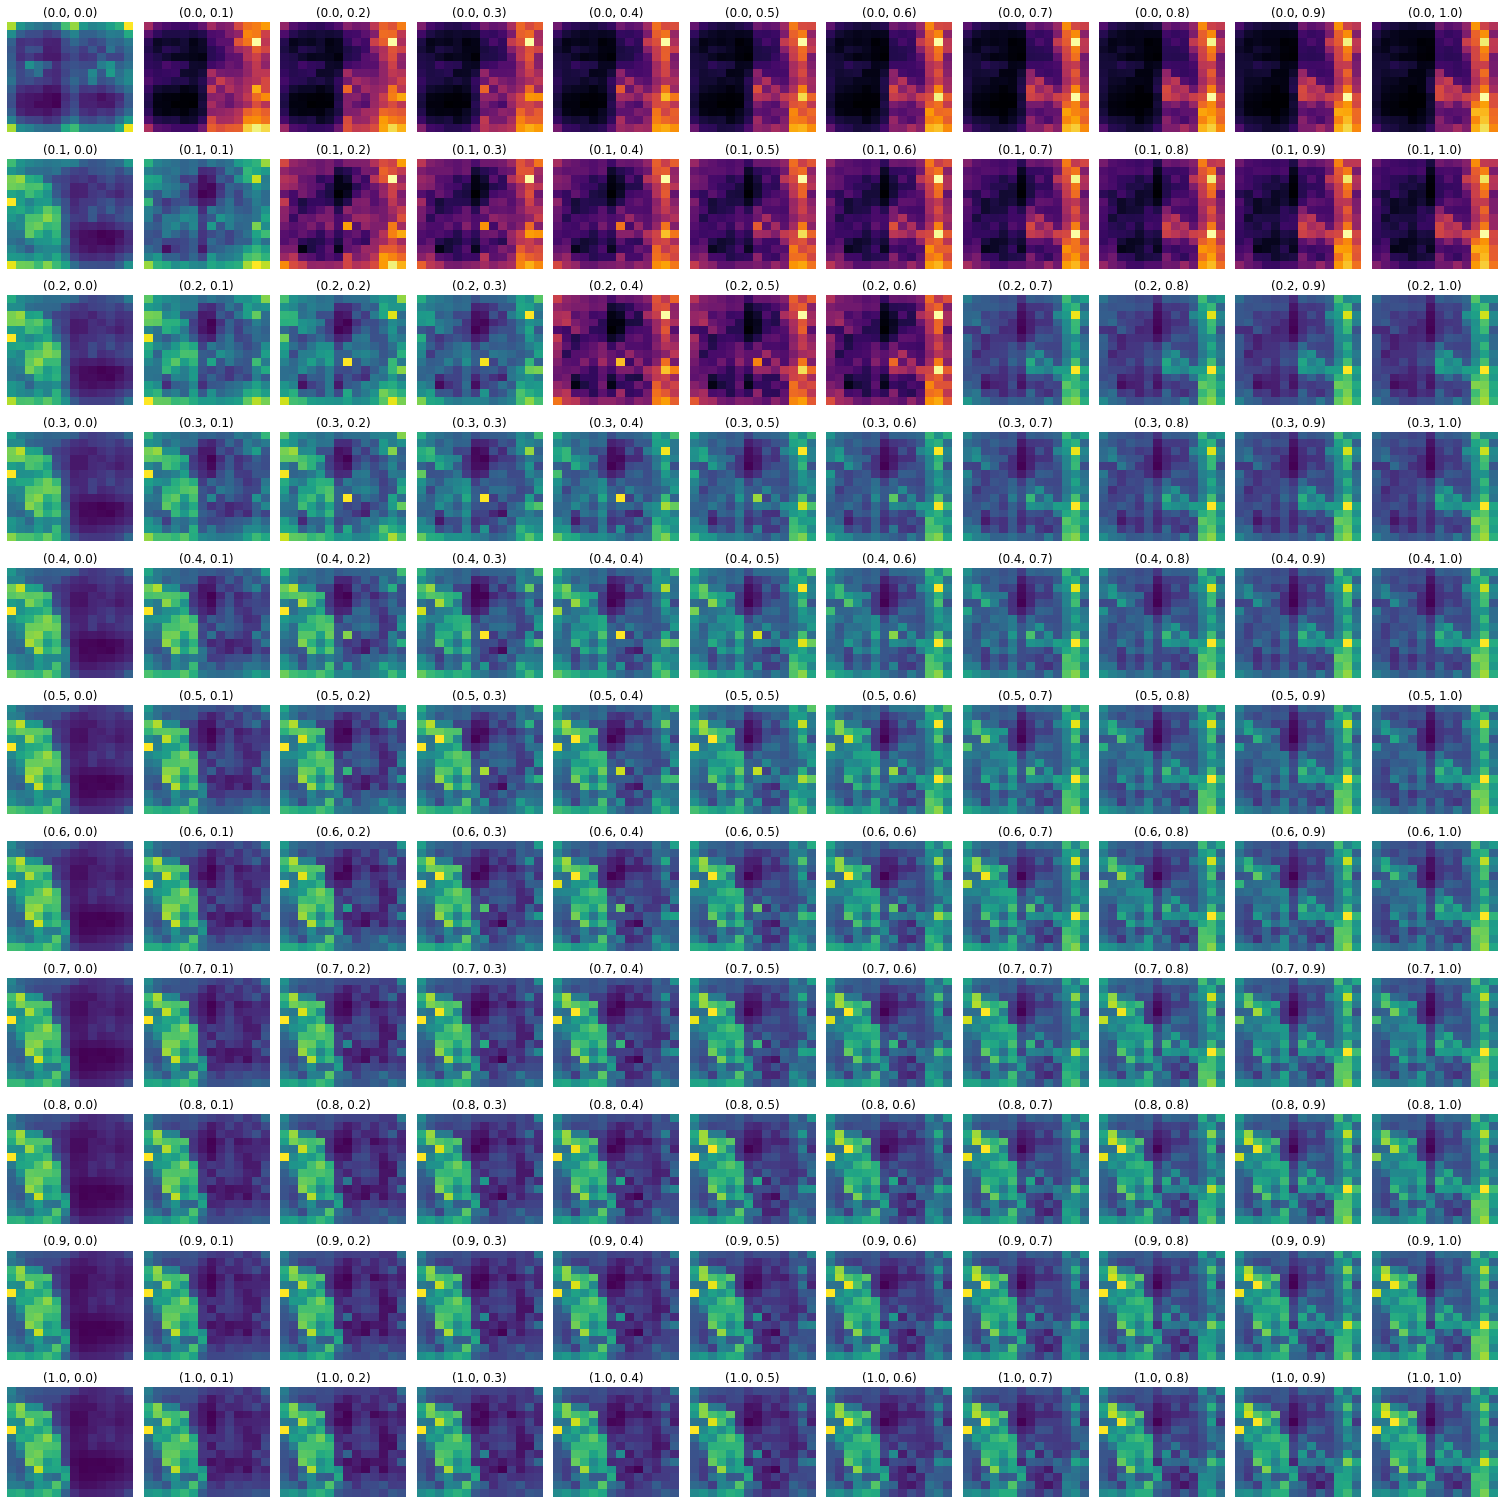

In [21]:
f,ax = plt.subplots(11,11, figsize=[21,21])

for ii in range(11):
    for jj in range(11):
        if log_ratio[ii,jj] >= 0: cmap = 'viridis'
        else: cmap='inferno'
        ax[ii,jj].imshow(maps_contrast[ii,jj], cmap=cmap)
        ax[ii,jj].set_title(f'({np.round(contrasts[ii],1)}, {np.round(contrasts[jj],1)})')
        ax[ii,jj].axis('off')

plt.tight_layout()
plt.show()

---
### 3. Attention modulation

Can we bias the network behavior by modulating its attention? Here, I weighted the self-attention matrices from a subset of layers $L$ with a coefficient $w ^l$ as follows:

$$
\tilde{\mathbf{A}}^l = w^l \cdot \mathbf{A}^l {\big\vert}_\mathrm{Left} + (1-w^l) \cdot \mathbf{A}^l {\big\vert}_\mathrm{Right}, \ \ \forall l \in L
$$

Network behavior with attention modulation is computed by a forward pass with updated attention matrices. 

In [24]:
def forward_with_modulation(model, outputs, modulation_weights=np.repeat(0.5,12), grid_size=14):
    """ 
    Object classification with attention modulation in ViT
    
    Parameters
    ----------
    model : pytorch ViT model
    outputs : model outputs (should containt hidden states)
    modulation_weights : attention weights of the left side of image
    grid_size : length of square consisting of patches
    
    Returns
    -------
    logits : final class soft prediction
    attentions : QK.T matrices 
    """
    
    half_size  = int(grid_size/2)
    attentions = []    
    with torch.no_grad():
                
        for l in range(12):
            # modulation weights
            w_L = modulation_weights[l]
            
            # get hidden state
            if l == 0:
                hidden_state = outputs['hidden_states'][0]
            else:
                hidden_state = layer_attn_attention_outout

            # ViTLayer
            layer         = model.vit.encoder.layer[l]
            layer_before  = layer.layernorm_before
            layer_after   = layer.layernorm_after
            layer_attn    = layer.attention
            layer_interm  = layer.intermediate
            layer_out     = layer.output

            # ViTLayer - outputs
            layer_outputs = layer(hidden_state, None, output_attentions=True) # [0] == outputs['hidden_states'][-1]

            # ViTLayer_attn
            layer_attn_attention = layer_attn.attention
            layer_attn_output    = layer_attn.output    

            # ViTLayer_attn: QK and V (ViTAttention & ViTSelfAttention)
            layer_attn_attention_qk = layer_attn_attention(
                layer_before(hidden_state), None, output_attentions=True
            )[1] # = outputs['attentions'][-1] == softmax(score, dim=-1), where score=qk.T/sqrt(d)

            for i in range(grid_size):
                layer_attn_attention_qk[:,:,:, (1+grid_size*i) : (1+grid_size*i+half_size) ]     *= w_L
                layer_attn_attention_qk[:,:,:, (1+grid_size*i+half_size) : (1+grid_size*(i+1)) ] *= (1.-w_L)
            layer_attn_attention_qk /= layer_attn_attention_qk.sum(dim=-1).unsqueeze(-1)    
            attentions.append(layer_attn_attention_qk)

            layer_attn_attention_v  = layer_attn_attention.transpose_for_scores(
                layer_attn_attention.value(
                    layer_before(hidden_state)
                )
            )
            layer_attn_attention_qkv = torch.matmul(layer_attn_attention_qk, layer_attn_attention_v)
            layer_attn_attention_qkv = layer_attn_attention_qkv.permute(0, 2, 1, 3).contiguous()
            _shape                   = layer_attn_attention_qkv.size()[:-2] + (layer_attn_attention.all_head_size,)
            layer_attn_attention_qkv = layer_attn_attention_qkv.view(*_shape)
            layer_attn_attention_out = layer_attn_output(layer_attn_attention_qkv, hidden_state) # == layer_attn(layer_before(hidden_state))[0]

            # ViTLayer_attn: Output with residual connection
            hidden_state_resid          = layer_attn_attention_out + hidden_state # 1st residual connection
            layer_attn_attention_outout = layer_after(hidden_state_resid)
            layer_attn_attention_outout = layer_interm(layer_attn_attention_outout)
            layer_attn_attention_outout = layer_out(layer_attn_attention_outout, hidden_state_resid) # 2nd residual connection
            
        logits  = model.classifier(model.vit.layernorm(layer_attn_attention_outout)[:, 0, :])
        
    return logits, tuple(attentions)

#### 3.1. Contrast modulation plot

+ with attention modulation of $7-12$ layers

In [31]:
# no weights to 1-6 layers, low weights to 7-12 layers
weights = np.array([0.5] * 6 + [0.01] * 6)

In [33]:
mod_maps_contrast  = np.zeros([len(contrasts),len(contrasts),14,14]) * np.nan
mod_prob_contrast  = np.zeros([len(contrasts),len(contrasts),2]) * np.nan

print('Warning: this block can take some minutes!')
for ic_i, ic_v in enumerate(contrasts):
    for jc_i, jc_v in enumerate(contrasts):
        image1 = preprocess(images[image_list[img1]])
        image1 = transforms.functional.adjust_contrast(image1, contrast_factor=ic_v) # 0.75, 0.8, # 0.15, 0.2
        image2 = preprocess(images[image_list[img2]])
        image2 = transforms.functional.adjust_contrast(image2, contrast_factor=jc_v) # 0.75, 0.8, # 0.15, 0.2
        x      = torch.concat([image1,image2],axis=-1)
        inputs = feature_extractor(images=x, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            
        logits, attentions = forward_with_modulation(model, outputs, modulation_weights=weights)

        # 
        probs = torch.nn.Softmax(dim=-1)(logits)
        mod_prob_contrast[ic_i,jc_i,0] = probs[0,int(idx_single[img1])].item()
        mod_prob_contrast[ic_i,jc_i,1] = probs[0,int(idx_single[img2])].item()
        
        attn_map = compute_attention_map(attentions)
        mod_maps_contrast[ic_i,jc_i] = attn_map
        
    print(f'Done:\t{np.round((ic_i+1)/11.*100)}%')
    
mod_log_ratio = np.log(mod_prob_contrast[:,:,0]/mod_prob_contrast[:,:,1])

Done:	9.0%
Done:	18.0%
Done:	27.0%
Done:	36.0%
Done:	45.0%
Done:	55.0%
Done:	64.0%
Done:	73.0%
Done:	82.0%
Done:	91.0%
Done:	100.0%


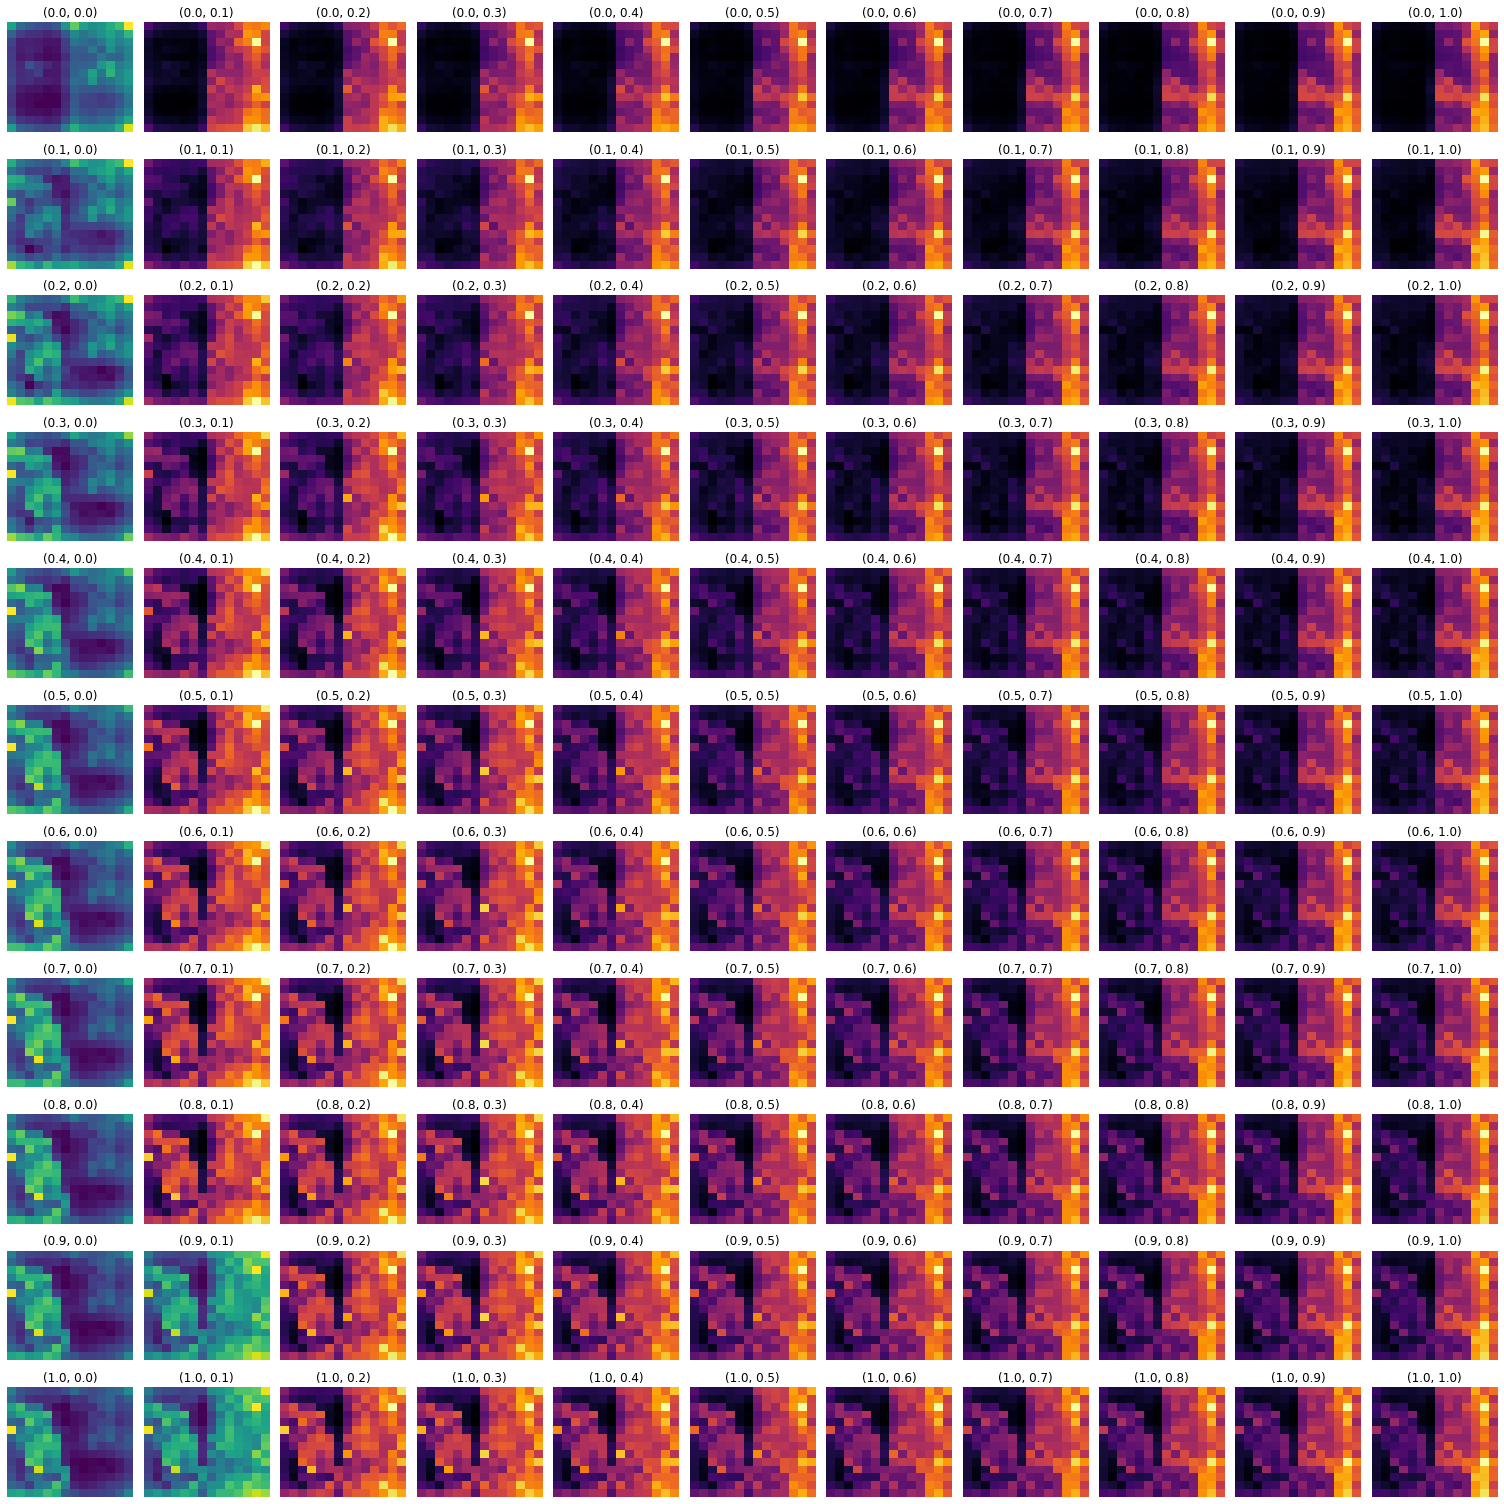

In [34]:
f,ax = plt.subplots(11,11, figsize=[21,21])

for ii in range(11):
    for jj in range(11):
        if mod_log_ratio[ii,jj] >= 0: cmap = 'viridis'
        else: cmap='inferno'
        ax[ii,jj].imshow(mod_maps_contrast[ii,jj], cmap=cmap)
        ax[ii,jj].set_title(f'({np.round(contrasts[ii],1)}, {np.round(contrasts[jj],1)})')
        ax[ii,jj].axis('off')

plt.tight_layout()
plt.show()

#### 3.2. Comparison of early versus late layers

+ Comparison of attention modulation of $1-6$ layers versus $7-12$ layers for a full-contrast image

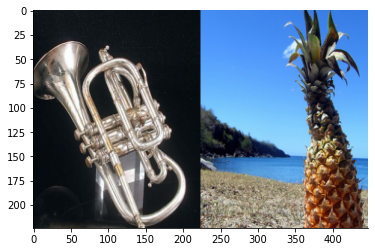

In [57]:
plt.imshow(x.detach().numpy().transpose((1,2,0)))

In [61]:
image1 = preprocess(images[image_list[img1]])
image2 = preprocess(images[image_list[img2]])
# image1 = transforms.functional.adjust_contrast(image1, contrast_factor=0.5)
# image2 = transforms.functional.adjust_contrast(image2, contrast_factor=0.5)
x      = torch.concat([image1,image2],axis=-1)
inputs = feature_extractor(images=x, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True)
    
weights_no    = np.array([0.5] * 12)
weights_early = np.array([0.01] * 6 + [0.5] * 6)
weights_late  = np.array([0.5] * 6 + [0.01] * 6)

logits_no    = forward_with_modulation(model, outputs, modulation_weights=weights_no)[0][0].detach().numpy()
logits_early = forward_with_modulation(model, outputs, modulation_weights=weights_early)[0][0].detach().numpy()
logits_late  = forward_with_modulation(model, outputs, modulation_weights=weights_late)[0][0].detach().numpy()

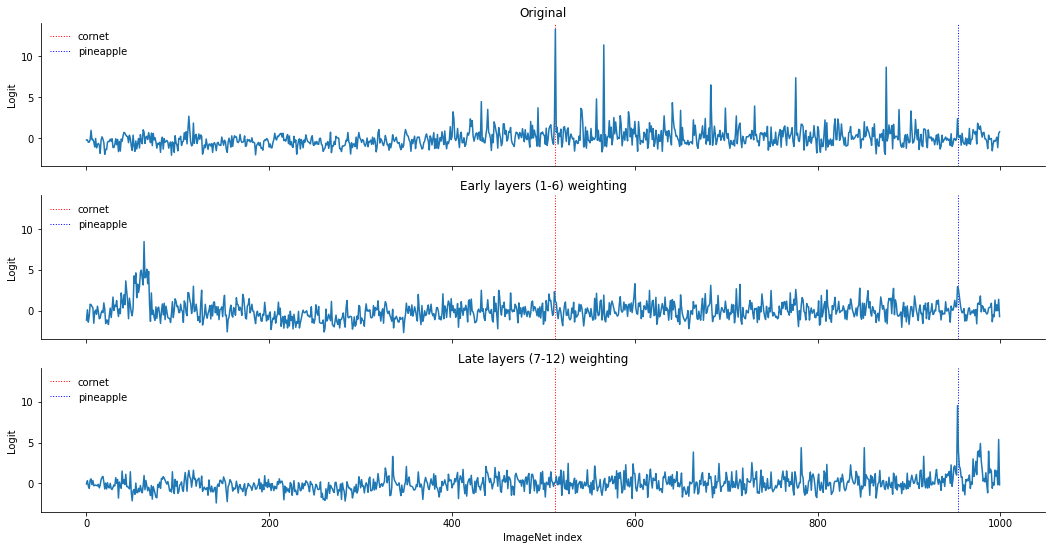

In [69]:
f,ax = plt.subplots(3,1,figsize=[18,9], sharey=True, sharex=True)

for i_fig in range(3):
    ax[i_fig].set_ylabel('Logit')
    ax[i_fig].axvline(idx_single[img1], color='red',  linestyle='dotted', label=image_list[img1], linewidth=1)
    ax[i_fig].axvline(idx_single[img2], color='blue', linestyle='dotted', label=image_list[img2], linewidth=1)
    ax[i_fig].legend(frameon=False)
ax[0].plot(logits_no);    ax[0].set_title('Original')
ax[1].plot(logits_early); ax[1].set_title('Early layers (1-6) weighting')
ax[2].plot(logits_late);  ax[2].set_title('Late layers (7-12) weighting')
ax[2].set_xlabel('ImageNet index')
plt.show()